In [1]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import os
from tqdm import tqdm
import tensorflow as tf
import glob
import pandas as pd
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM
from keras.layers import Flatten, Dense, TimeDistributed


In [174]:
!kaggle datasets download -d mmoreaux/audio-cats-and-dogs

Dataset URL: https://www.kaggle.com/datasets/mmoreaux/audio-cats-and-dogs
License(s): CC-BY-SA-3.0
audio-cats-and-dogs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [175]:
!unzip audio-cats-and-dogs.zip

Archive:  audio-cats-and-dogs.zip
replace cats_dogs/cat_1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
ROOT_DIR = './cats_dogs/'
CSV_PATH = './train_test_split.csv'


In [16]:
def signal_padding(y):
  all_padding = 400000 - y.shape[0]
  if all_padding < 0:
    return y[:400000]
  start = np.zeros(all_padding//2)
  end = np.zeros(all_padding-start.shape[0])
  signal = np.concatenate([start, y, end], axis=0)
  return signal

In [17]:
def melspectrogram(y, label):
  D = np.abs(librosa.stft(y))**2
  S = librosa.feature.melspectrogram(S=D, sr=22050)
  S = librosa.amplitude_to_db(S)
  label = "cat" if label == 0 else "dog"
  # plt.figure(figsize=(12,4))

  # librosa.display.specshow(S, sr=22050, x_axis='time', y_axis='mel')

  # plt.title(f'{label} mel power spectrogram')

  # plt.colorbar(format='%+02.0f dB')

  # plt.tight_layout()
  return S

In [18]:
def time_shift(y, shift_pct):
  return np.roll(y, int(random.random() * shift_pct * y.shape[0]))


In [19]:
data = {"name" : [], "label": [], "duration": [], "sampling_rate" : [], "timestep" : [] }
map_label = {0 : "cat", 1 : "dog"}
X = []
y = []
for f in os.listdir(ROOT_DIR):
  if f.endswith('.wav'):
    yy, sr = librosa.load(ROOT_DIR + f)
    duration = librosa.get_duration(y=yy, sr=sr)
    data["name"].append(f)
    label = 0 if f.startswith("cat") else 1
    data["sampling_rate"].append(sr)
    data["duration"].append(duration)
    data['timestep'].append(yy.shape[0])
    data['label'].append(map_label[label])
    sig = signal_padding(yy)
    X.append(sig)
    X.append(time_shift(sig, 0.4))
    y.append(label)
    y.append(label)
assert len(data['name']) == len(data['label']) == len(data['duration']) == len(data['sampling_rate'])




In [20]:
df = pd.DataFrame(data)

In [21]:
df.set_index('name')

,label,duration,sampling_rate,timestep
name,,,,
dog_barking_65.wav,dog,3.896100,22050,85909
cat_45.wav,cat,17.340000,22050,382347
cat_102.wav,cat,11.400000,22050,251370
cat_41.wav,cat,10.900000,22050,240345
cat_32.wav,cat,2.533968,22050,55874
...,...,...,...,...
cat_35.wav,cat,11.000000,22050,242550
dog_barking_17.wav,dog,3.092018,22050,68179
dog_barking_44.wav,dog,4.211837,22050,92871


In [22]:
df.describe()

,duration,sampling_rate,timestep
count,277.000000,277.0,277.000000
mean,6.939858,22050.0,153023.866426
std,4.586222,0.0,101126.184369
min,0.923356,22050.0,20360.000000
25%,2.593605,22050.0,57189.000000
50%,5.896417,22050.0,130016.000000
75%,11.800000,22050.0,260190.000000
max,17.976009,22050.0,396371.000000


<Axes: xlabel='label', ylabel='count'>

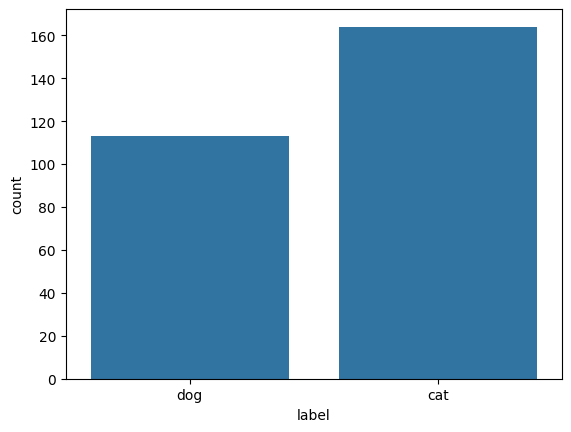

In [23]:

sns.countplot(df, x="label")

(array([71., 49., 21., 15., 13., 19., 74.,  4.,  6.,  5.]),
 array([ 0.92335601,  2.62862132,  4.33388662,  6.03915193,  7.74441723,
         9.44968254, 11.15494785, 12.86021315, 14.56547846, 16.27074376,
        17.97600907]),
 <BarContainer object of 10 artists>)

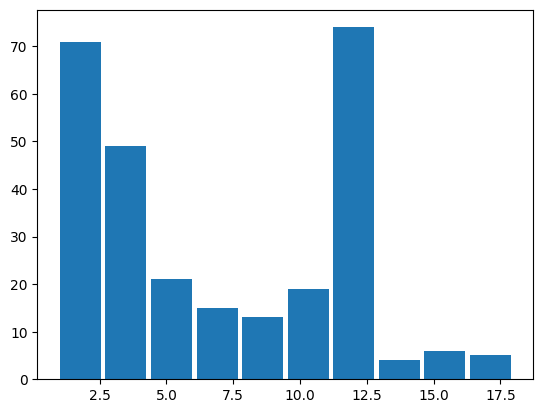

In [24]:
plt.hist(df['duration'], rwidth=0.9)

[-0.00307443 -0.00346477 -0.00292816 ...  0.0057973   0.00437561
  0.        ]
(390021,)


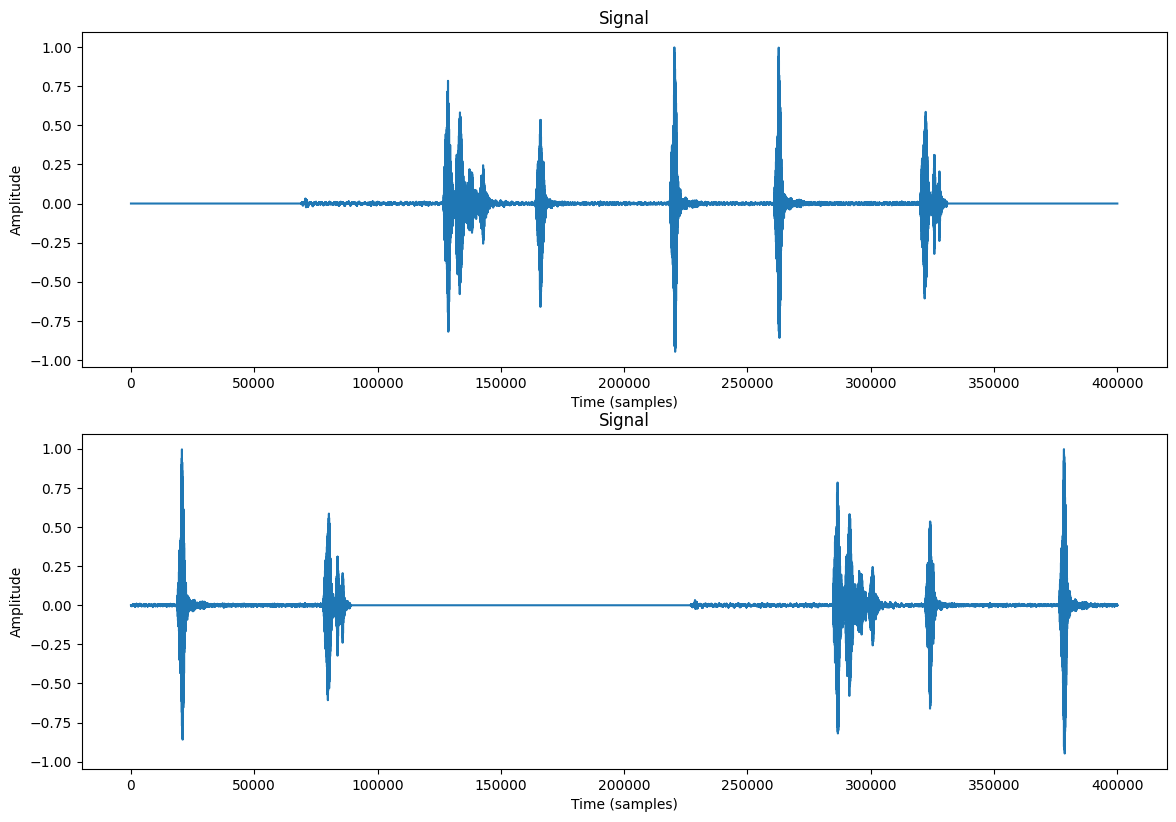

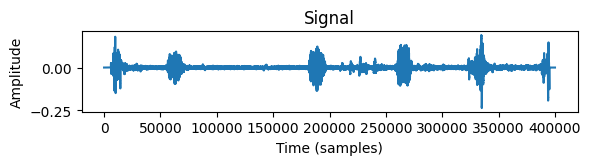

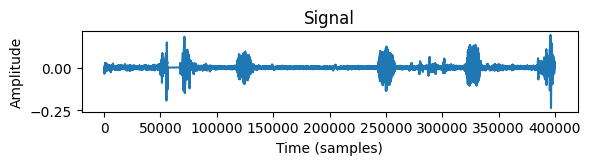

In [25]:
y_dog, sr = librosa.load('/content/cats_dogs/dog_barking_96.wav')
y_cat, sr = librosa.load('/content/cats_dogs/cat_69.wav')
print(y_dog)
print(y_cat.shape)
y_dog = signal_padding(y_dog)
y_dog_shift = time_shift(y_dog, 0.4)
y_cat = signal_padding(y_cat)
y_cat_shift = time_shift(y_cat, 0.4)

plt.figure(figsize=(14,20))
plt.subplot(4,1,1)
plt.plot(y_dog)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.subplot(4,1,2)
plt.plot(y_dog_shift)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()
plt.subplot(4,1, 3)
plt.plot(y_cat)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()
plt.subplot(4,1, 4)
plt.plot(y_cat_shift)
plt.title('Signal')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.show()

In [26]:
X = [ melspectrogram(xx, yy) for xx, yy  in zip(X, y) ]

In [27]:
scaler = MinMaxScaler()
X = [scaler.fit_transform(xx) for xx in X]

In [28]:
X = np.array(X)
y = np.array(y)

### LSTM

In [29]:
X_LSTM = X
y_LSTM = y

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_LSTM,y_LSTM ,random_state=42, train_size=0.7, shuffle=True)

In [31]:
X_train.shape

(387, 128, 782)

In [32]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dense(8,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy'
, metrics= ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128, 256)            │       1,063,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128, 8)              │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,067,017 (4.07 MB)

 Trainable params: 1,067,017 (4.07 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.fit(X_train,y_train,epochs=20)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7364 - loss: 0.5537
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8884 - loss: 0.3174
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9078 - loss: 0.2706
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9423 - loss: 0.1611
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9802 - loss: 0.1438
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9814 - loss: 0.0808
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9836 - loss: 0.0488
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9951 - loss: 0.0390
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9927 - loss: 0.0224
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0087
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0074
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy:

In [34]:
y_pred = model.predict(X_test)
y_pred = [ 1 if y > 0.5 else 0 for y in y_pred ]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [35]:
accuracy = accuracy_score(y_test, y_pred)
print("\nLSTM Accuracy:", accuracy)
print("Classification Report for LSTM:\n", classification_report(y_test, y_pred))
print("Confusion Matrix for LSTM:\n", confusion_matrix(y_test, y_pred))


LSTM Accuracy: 0.874251497005988
Classification Report for LSTM:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90       106
           1       0.87      0.77      0.82        61

    accuracy                           0.87       167
   macro avg       0.87      0.85      0.86       167
weighted avg       0.87      0.87      0.87       167

Confusion Matrix for LSTM:
 [[99  7]
 [14 47]]


Text(50.722222222222214, 0.5, 'Actual')

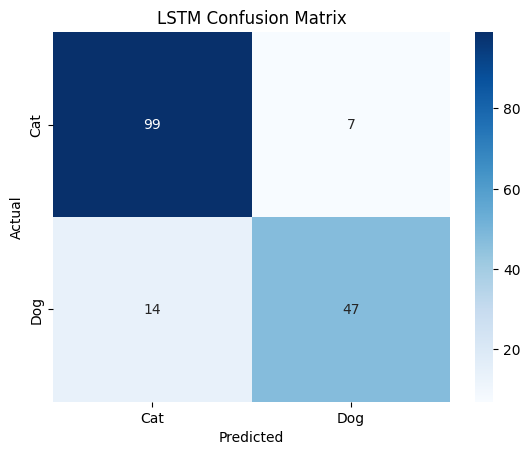

In [36]:
labels = ['Cat', 'Dog']
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')


### CNN

In [37]:
X_CNN = X[...,np.newaxis]
y_CNN = y

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_CNN,y_CNN ,random_state=42, train_size=0.7, shuffle=True)


In [39]:
model = Sequential()
model.add(Conv2D(128, (3,3),activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2,2))
model.add(Dense(8,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy'
, metrics= ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 780, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 390, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 63, 390, 8)          │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 196560)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │         196,561 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,873 (776.85 KB)

 Trainable params: 198,873 (776.85 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.fit(X_train,y_train,epochs=20)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.5576 - loss: 0.6567
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8705 - loss: 0.4153
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.8928 - loss: 0.2956
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9587 - loss: 0.1840
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9685 - loss: 0.1174
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9887 - loss: 0.0553
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9686 - loss: 0.1521
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9968 - loss: 0.0390
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9925 - loss: 0.0459
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9946 - loss: 0.0317
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9961 - loss: 0.0227
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/ste

In [41]:
y_pred = model.predict(X_test)
y_pred = [ 1 if y > 0.5 else 0 for y in y_pred ]


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step


In [42]:
accuracy = accuracy_score(y_test, y_pred)
print("\nLSTM Accuracy:", accuracy)
print("Classification Report for LSTM:\n", classification_report(y_test, y_pred))
print("Confusion Matrix for LSTM:\n", confusion_matrix(y_test, y_pred))


LSTM Accuracy: 0.844311377245509
Classification Report for LSTM:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88       106
           1       0.77      0.82      0.79        61

    accuracy                           0.84       167
   macro avg       0.83      0.84      0.83       167
weighted avg       0.85      0.84      0.85       167

Confusion Matrix for LSTM:
 [[91 15]
 [11 50]]


Text(50.722222222222214, 0.5, 'Actual')

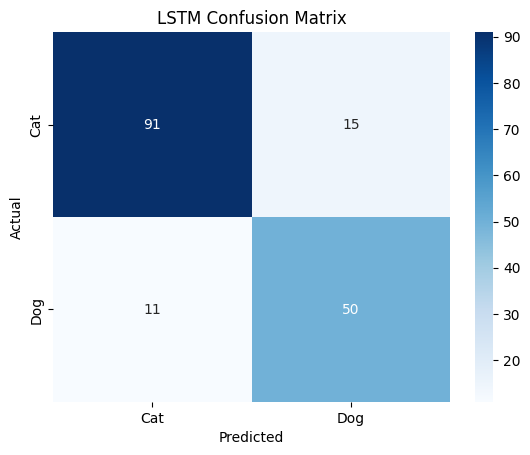

In [43]:
labels = ['Cat', 'Dog']
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')


### CNN - LSTM

In [44]:
X_COMBINED = X[:,np.newaxis,...,np.newaxis]


In [45]:
print(X_COMBINED.shape)

(554, 1, 128, 782, 1)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_COMBINED,y ,random_state=42, train_size=0.7, shuffle=True)

In [47]:
X_train.shape

(387, 1, 128, 782, 1)

In [48]:
tf.keras.backend.clear_session()

In [49]:
model = Sequential()
model.add(TimeDistributed(Conv2D(1,3,activation='relu'), input_shape=X_train.shape[1:]))
model.add(TimeDistributed(MaxPooling2D(2, 2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(8,activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy'
, metrics= ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 1, 126, 780, 1)      │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 1, 63, 390, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 1, 24570)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1, 128)              │      12,645,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1, 8)                │           1,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,646,939 (48.24 MB)

 Trainable params: 12,646,939 (48.24 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.fit(X_train,y_train,epochs=20)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6477 - loss: 0.6151
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8780 - loss: 0.3800
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9318 - loss: 0.2382
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9823 - loss: 0.1036
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9897 - loss: 0.0447
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9992 - loss: 0.0211
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9953 - loss: 0.0120
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9968 - loss: 0.0116
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0087
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.0096
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0048
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy:

In [51]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [52]:
y_pred = [ 1 if y > 0.5 else 0 for y in y_pred ]

In [53]:
accuracy = accuracy_score(y_test, y_pred)
print("\nLSTM Accuracy:", accuracy)
print("Classification Report for LSTM:\n", classification_report(y_test, y_pred))
print("Confusion Matrix for LSTM:\n", confusion_matrix(y_test, y_pred))


LSTM Accuracy: 0.8922155688622755
Classification Report for LSTM:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92       106
           1       0.88      0.82      0.85        61

    accuracy                           0.89       167
   macro avg       0.89      0.88      0.88       167
weighted avg       0.89      0.89      0.89       167

Confusion Matrix for LSTM:
 [[99  7]
 [11 50]]


Text(50.722222222222214, 0.5, 'Actual')

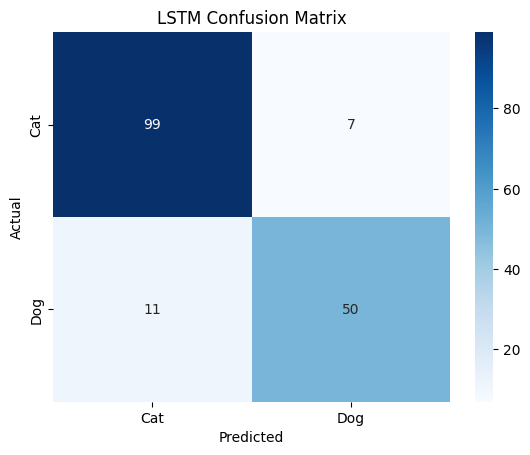

In [54]:
labels = ['Cat', 'Dog']
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',xticklabels=labels, yticklabels=labels)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')


In [72]:
#load sound data from external source
dog, sr = librosa.load('/content/dog-barking-34671.mp3')
sig = signal_padding(dog)
mel = melspectrogram(sig, 0)
mel = scaler.fit_transform(mel)

print(mel.shape)
mel = mel[np.newaxis,np.newaxis,...,np.newaxis]

y_pred = model.predict(mel)
print(y_pred > 0.5)

(128, 782)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[ True]]
